<a href="https://colab.research.google.com/github/AnnaScibska/Deep_learning_flowers_data_set/blob/master/ddone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello,

This is my final model for dataset: [flower recognition - kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition)

Max accuracy I was able to achieve on the train data is 88%. 

In the dataset there's plenty of pictures that are bad example: 
- person holding a tiny flower, 
- a bug sitting on the flower, where the flower is only a foggy background, 
- and the hardest of them all: a field of flowers - you have to take a close look to recognize which flower is on the particular picture,
- etc. 

So for the given dataset I think the result is not that bad :)

I was struggling with the overfitting - I had huge drop of accuracy at the beginning when evaluating model after finishing training with 99% accuracy (hence validation during the training and training ceiling).

I gain some accuracy by adding additional convolution and pooling layers.

It help a lot to increase the dataset size by adding pictures flipped horizontally.

The best solution for overfitting was **ImageDataGenerator** that boosted the accuracy to the descent level.

I experimented with number of neurons in a layer, batch size, learning rate etc. And this is the best I could come up with.

Although it was fun :) I had to stop at one point.

## Imports

In [0]:
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

## Upload data from kaggle

In [3]:
file = open('/content/kaggle.json', 'w')
file.write('{\"username\":\"freeanke\",\"key\":\"92b509cecb01045514b22adb0910675c\"}')
file.close()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

## Data pre-processing

In [0]:
img_size = 150

#===# creating dataset
def load_imgs_and_labels(filepaths, flip=False):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_image( './' + str(path), flip))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

#===# processing one image
# loading the file
# optionally: flipping horizontally
# resizing
# rescaling

def process_image(filepath, flip):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
    if flip:
      img = cv2.flip(img, 1)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img/255
    
  except Exception as e:
    print(str(e))

  return img

#===# working around labels
def translate_label_from_str_to_int(str_label):
  labels = {
      "sunflower": 0,
      "rose": 1,
      "dandelion": 2,
      "daisy": 3,
      "tulip": 4
  }
  return labels.get(str_label)

def translate_label_from_int_to_str(int_label):
  labels = {
      0: "sunflower",
      1: "rose",
      2: "dandelion",
      3: "daisy",
      4: "tulip"
  }
  return labels.get(int_label)

## Import the files

In [0]:
data_dir = pathlib.Path('flowers/flowers')
file_paths = np.array(list(data_dir.glob('*/*.jpg')))

Load data

In [6]:
np.random.shuffle(file_paths)
datas = load_imgs_and_labels(file_paths)

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


Add data - images flipped horizontally

In [7]:
np.random.shuffle(file_paths)
flipped_datas = load_imgs_and_labels(file_paths, True)
datas[0] = datas[0] + flipped_datas[0]
datas[1] = datas[1] + flipped_datas[1]

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


Divide dataset into training and testing part

In [0]:
dataset = datas[0]
labels = datas[1]

ds_size = len(datas[0])

test_data = dataset[:ds_size:5]
test_labels = labels[:ds_size:5]

train_data = np.delete(dataset, slice(0, ds_size, 5), 0)
train_labels = np.delete(labels, slice(0, ds_size, 5))

Display test picture with label

rose


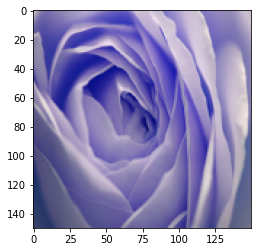

In [9]:
print(translate_label_from_int_to_str(train_labels[500]))
plt.imshow(train_data[500])
plt.show()

## Creating, training and testing a model

## **Model 1**. No data generator. Accuracy: **80%**

In [0]:
#==# stopping the model from overfitting
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
epochs=100
batch_size=100

In [0]:
callbacks = training_ceiling()

In [0]:
model = tf.keras.models.Sequential([
                                    
    #===# image processing
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    #===# output
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)       

In [0]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.fit(
    np.asarray(train_data), 
    np.asarray(train_labels), 
    validation_data=(np.asarray(test_data),np.asarray(test_labels)), 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[callbacks])

Epoch 1/100
70/70 [==============================] - 4s 53ms/step - loss: 1.4068 - accuracy: 0.3700 - val_loss: 1.2400 - val_accuracy: 0.4410
Epoch 2/100
70/70 [==============================] - 4s 52ms/step - loss: 1.1322 - accuracy: 0.5263 - val_loss: 1.0756 - val_accuracy: 0.5740
Epoch 3/100
70/70 [==============================] - 4s 51ms/step - loss: 1.0187 - accuracy: 0.5849 - val_loss: 1.0054 - val_accuracy: 0.6040
Epoch 4/100
70/70 [==============================] - 4s 52ms/step - loss: 0.9313 - accuracy: 0.6213 - val_loss: 0.9450 - val_accuracy: 0.6139
Epoch 5/100
70/70 [==============================] - 4s 51ms/step - loss: 0.8400 - accuracy: 0.6663 - val_loss: 0.8471 - val_accuracy: 0.6642
Epoch 6/100
70/70 [==============================] - 4s 51ms/step - loss: 0.7925 - accuracy: 0.6955 - val_loss: 0.8140 - val_accuracy: 0.6902
Epoch 7/100
70/70 [==============================] - 4s 52ms/step - loss: 0.7541 - accuracy: 0.7099 - val_loss: 0.7923 - val_accuracy: 0.6971
Epoch 

## Evaluating the model 1

In [25]:
model.evaluate(np.asarray(test_data), np.asarray(test_labels))

55/55 [==============================] - 0s 9ms/step - loss: 1.1800 - accuracy: 0.8012


[1.1799767017364502, 0.8011560440063477]

## **Model 2**. With data generator. Accuracy: **88%**

In [10]:
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = training_ceiling()

epochs=100
batch_size=128

model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        )
data_generator.fit(np.asarray(train_data))

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    data_generator.flow(
        np.asarray(train_data),
        np.asarray(train_labels), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(test_data),
                     np.asarray(test_labels)),
    verbose = 1, 
    steps_per_epoch=np.asarray(train_data).shape[0] // batch_size,
    callbacks=[callbacks])

Epoch 1/100
54/54 [==============================] - 31s 567ms/step - loss: 1.3954 - accuracy: 0.3618 - val_loss: 1.2211 - val_accuracy: 0.4335
Epoch 2/100
54/54 [==============================] - 31s 571ms/step - loss: 1.1875 - accuracy: 0.4828 - val_loss: 1.1098 - val_accuracy: 0.5220
Epoch 3/100
54/54 [==============================] - 30s 560ms/step - loss: 1.1396 - accuracy: 0.5264 - val_loss: 1.0039 - val_accuracy: 0.5896
Epoch 4/100
54/54 [==============================] - 31s 568ms/step - loss: 1.0369 - accuracy: 0.5738 - val_loss: 0.9683 - val_accuracy: 0.6168
Epoch 5/100
54/54 [==============================] - 31s 566ms/step - loss: 0.9613 - accuracy: 0.6087 - val_loss: 0.9179 - val_accuracy: 0.6428
Epoch 6/100
54/54 [==============================] - 30s 564ms/step - loss: 0.9217 - accuracy: 0.6301 - val_loss: 0.8745 - val_accuracy: 0.6601
Epoch 7/100
54/54 [==============================] - 31s 566ms/step - loss: 0.8594 - accuracy: 0.6622 - val_loss: 0.8317 - val_accuracy:

## Evaluating the model 2

In [11]:
model.evaluate(np.asarray(test_data), np.asarray(test_labels))

55/55 [==============================] - 0s 8ms/step - loss: 0.4300 - accuracy: 0.8803


[0.4300357401371002, 0.8803468346595764]